# Введение в теорию вероятностей и статистику
В этом блокноте мы будем изучать некоторые из концепций, которые обсуждали ранее. Многие понятия из теории вероятностей и статистики хорошо представлены в основных библиотеках для обработки данных в Python, таких как `numpy` и `pandas`.


In [117]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

## Случайные переменные и распределения
Начнем с выборки из 30 значений из равномерного распределения от 0 до 9. Также вычислим среднее значение и дисперсию.


In [118]:
sample = [ random.randint(0,10) for _ in range(30) ]
print(f"Sample: {sample}")
print(f"Mean = {np.mean(sample)}")
print(f"Variance = {np.var(sample)}")

Sample: [0, 8, 1, 0, 7, 4, 3, 3, 6, 7, 1, 0, 6, 3, 1, 5, 9, 2, 4, 2, 5, 6, 8, 7, 1, 9, 8, 2, 3, 7]
Mean = 4.266666666666667
Variance = 8.195555555555556


Чтобы визуально оценить, сколько различных значений есть в выборке, мы можем построить **гистограмму**:


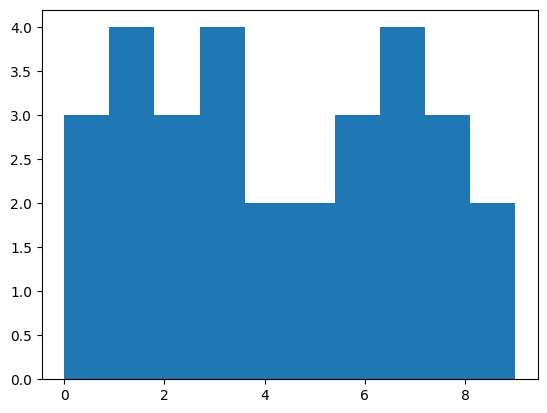

In [119]:
plt.hist(sample)
plt.show()

## Анализ реальных данных

Среднее значение и дисперсия играют важную роль при анализе данных из реального мира. Давайте загрузим данные о бейсболистах с [SOCR MLB Height/Weight Data](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights)


In [120]:
df = pd.read_csv("../../data/SOCR_MLB.tsv",sep='\t', header=None, names=['Name','Team','Role','Weight','Height','Age'])
df


Empty DataFrame
Columns: [Name, Team, Role, Weight, Height, Age]
Index: []


> Мы используем пакет [**Pandas**](https://pandas.pydata.org/) для анализа данных. Позже в этом курсе мы подробнее поговорим о Pandas и работе с данными в Python.

Давайте вычислим средние значения для возраста, роста и веса:


In [121]:
df[['Age','Height','Weight']].mean()

Age        28.736712
Height    201.726306
Weight     73.697292
dtype: float64

Теперь давайте сосредоточимся на росте и вычислим стандартное отклонение и дисперсию:


In [122]:
print(list(df['Height'])[:20])

[180, 215, 210, 210, 188, 176, 209, 200, 231, 180, 188, 180, 185, 160, 180, 185, 197, 189, 185, 219]


In [123]:
mean = df['Height'].mean()
var = df['Height'].var()
std = df['Height'].std()
print(f"Mean = {mean}\nVariance = {var}\nStandard Deviation = {std}")

Mean = 201.72630560928434
Variance = 441.6355706557866
Standard Deviation = 21.01512718628623


В дополнение к среднему имеет смысл рассмотреть медианное значение и квартили. Их можно визуализировать с помощью **ящиковой диаграммы**:


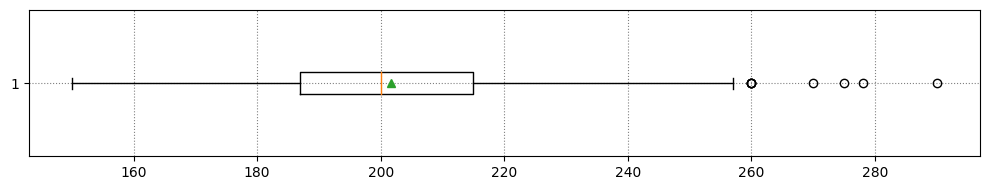

In [124]:
plt.figure(figsize=(10,2))
plt.boxplot(df['Height'], vert=False, showmeans=True)
plt.grid(color='gray', linestyle='dotted')
plt.tight_layout()
plt.show()

Мы также можем создавать коробчатые диаграммы для подмножеств нашего набора данных, например, сгруппированных по ролям игроков.


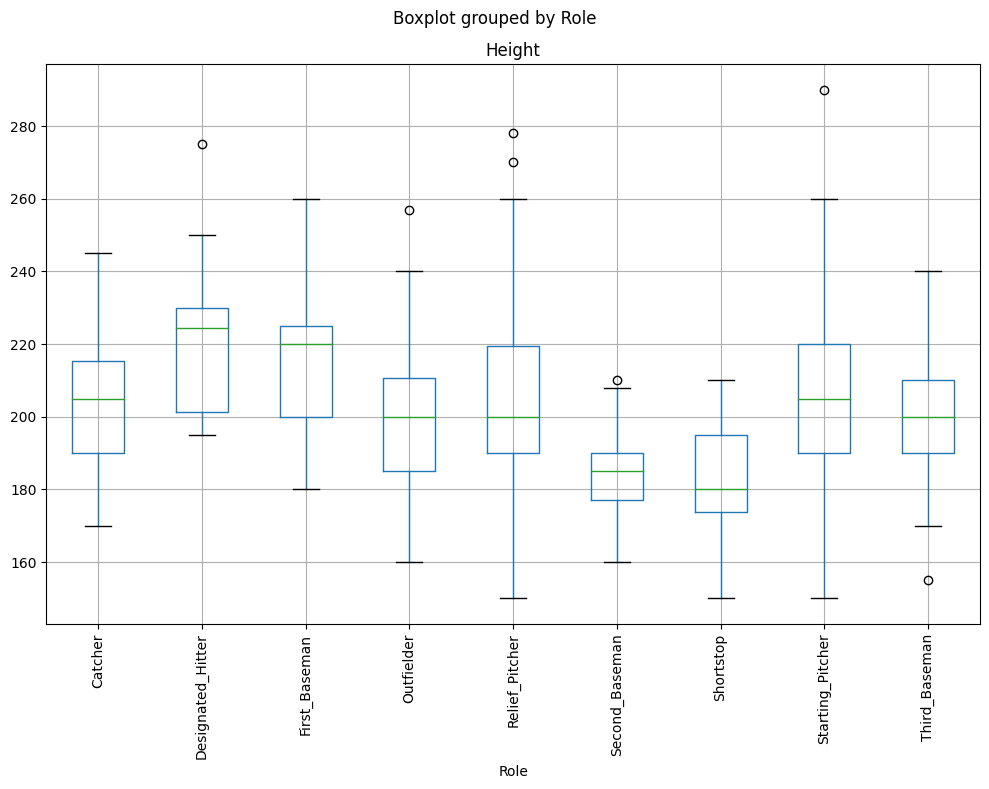

In [125]:
df.boxplot(column='Height', by='Role', figsize=(10,8))
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

> **Примечание**: Эта диаграмма предполагает, что в среднем рост первых базовых игроков выше, чем рост вторых базовых игроков. Позже мы узнаем, как можно более формально проверить эту гипотезу и как продемонстрировать, что наши данные статистически значимы, чтобы это показать.  

Возраст, рост и вес — это все непрерывные случайные величины. Как вы думаете, какова их распределение? Хороший способ узнать это — построить гистограмму значений:


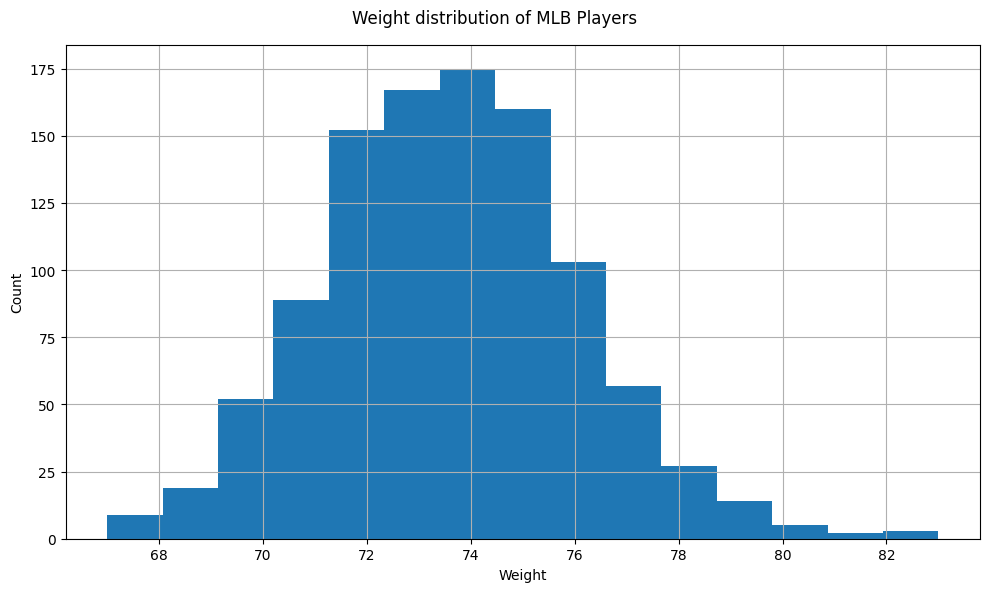

In [126]:
df['Weight'].hist(bins=15, figsize=(10,6))
plt.suptitle('Weight distribution of MLB Players')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Нормальное распределение

Давайте создадим искусственную выборку весов, которая будет следовать нормальному распределению с тем же средним и дисперсией, что и наши реальные данные:


In [127]:
generated = np.random.normal(mean, std, 1000)
generated[:20]

array([183.05261872, 193.52828463, 154.73707302, 204.27140391,
       203.88907247, 213.74665656, 225.10092364, 171.75867917,
       204.3521425 , 207.52870255, 158.53001756, 240.94399197,
       189.9909742 , 180.72442994, 173.4393402 , 175.98883711,
       197.86092769, 188.61598821, 234.19796698, 209.0295457 ])

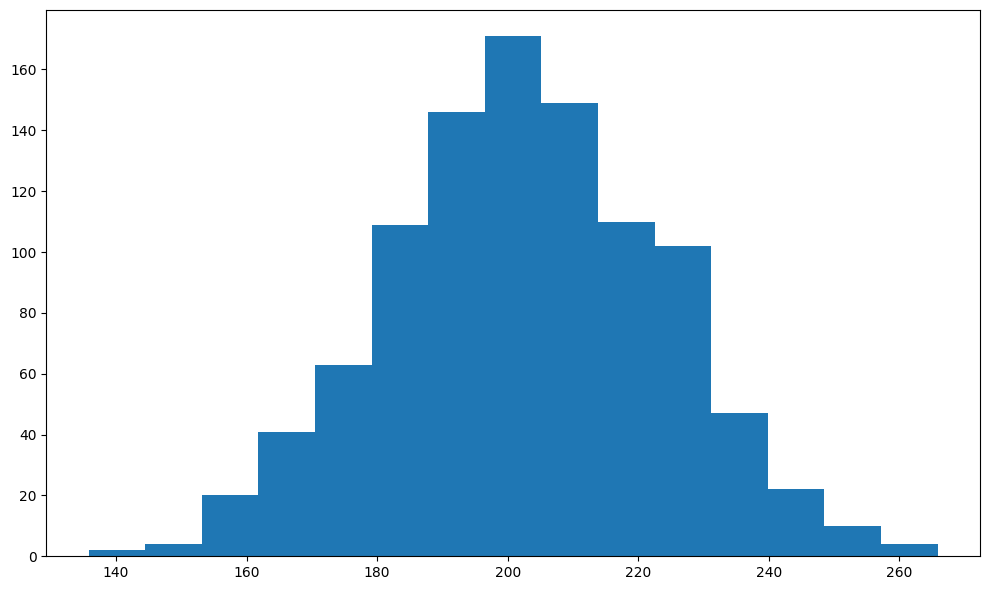

In [128]:
plt.figure(figsize=(10,6))
plt.hist(generated, bins=15)
plt.tight_layout()
plt.show()

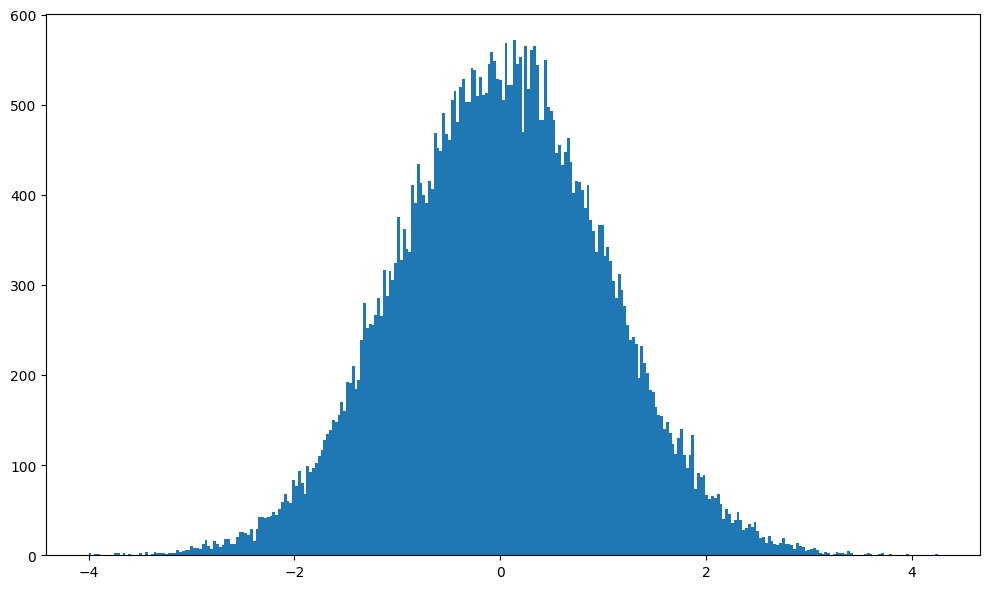

In [129]:
plt.figure(figsize=(10,6))
plt.hist(np.random.normal(0,1,50000), bins=300)
plt.tight_layout()
plt.show()

Поскольку большинство значений в реальной жизни имеют нормальное распределение, мы не должны использовать генератор случайных чисел с равномерным распределением для создания выборочных данных. Вот что происходит, если мы пытаемся сгенерировать веса с равномерным распределением (созданным с помощью `np.random.rand`):


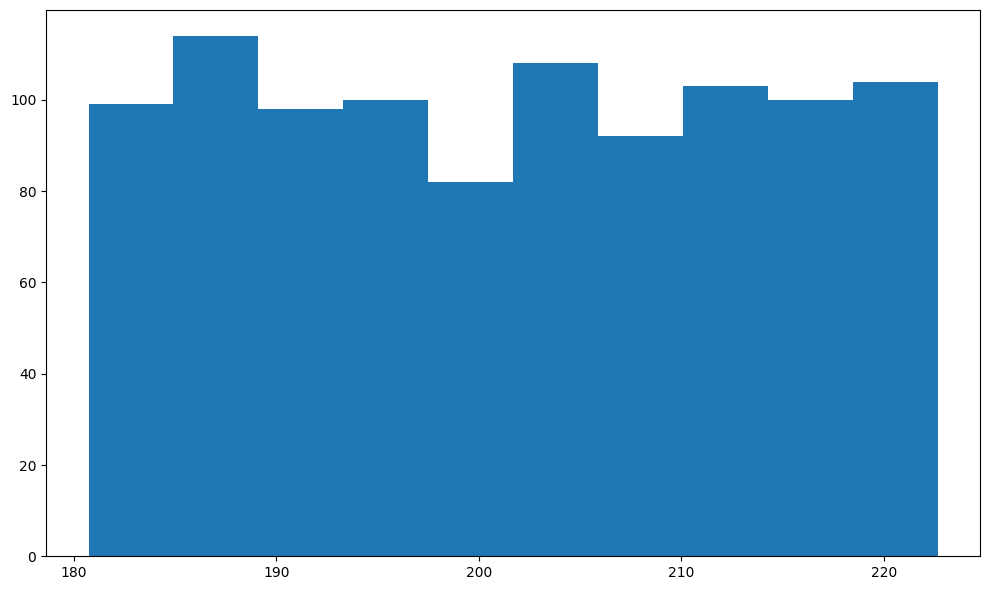

In [130]:
wrong_sample = np.random.rand(1000)*2*std+mean-std
plt.figure(figsize=(10,6))
plt.hist(wrong_sample)
plt.tight_layout()
plt.show()

## Доверительные интервалы

Давайте теперь рассчитаем доверительные интервалы для веса и роста бейсболистов. Мы будем использовать код [из этого обсуждения на stackoverflow](https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data):


In [131]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

for p in [0.85, 0.9, 0.95]:
    m, h = mean_confidence_interval(df['Weight'].fillna(method='pad'),p)
    print(f"p={p:.2f}, mean = {m:.2f} ± {h:.2f}")

p=0.85, mean = 73.70 ± 0.10
p=0.90, mean = 73.70 ± 0.12
p=0.95, mean = 73.70 ± 0.14


## Проверка гипотез

Давайте изучим различные роли в нашем наборе данных о бейсболистах:


In [132]:
df.groupby('Role').agg({ 'Weight' : 'mean', 'Height' : 'mean', 'Age' : 'count'}).rename(columns={ 'Age' : 'Count'})

Weight      Height  Count
Role                                           
Catcher            72.723684  204.328947     76
Designated_Hitter  74.222222  220.888889     18
First_Baseman      74.000000  213.109091     55
Outfielder         73.010309  199.113402    194
Relief_Pitcher     74.374603  203.517460    315
Second_Baseman     71.362069  184.344828     58
Shortstop          71.903846  182.923077     52
Starting_Pitcher   74.719457  205.321267    221
Third_Baseman      73.044444  200.955556     45

In [133]:
for p in [0.85,0.9,0.95]:
    m1, h1 = mean_confidence_interval(df.loc[df['Role']=='First_Baseman',['Height']],p)
    m2, h2 = mean_confidence_interval(df.loc[df['Role']=='Second_Baseman',['Height']],p)
    print(f'Conf={p:.2f}, 1st basemen height: {m1-h1[0]:.2f}..{m1+h1[0]:.2f}, 2nd basemen height: {m2-h2[0]:.2f}..{m2+h2[0]:.2f}')

Conf=0.85, 1st basemen height: 209.36..216.86, 2nd basemen height: 182.24..186.45
Conf=0.90, 1st basemen height: 208.82..217.40, 2nd basemen height: 181.93..186.76
Conf=0.95, 1st basemen height: 207.97..218.25, 2nd basemen height: 181.45..187.24


Мы видим, что интервалы не пересекаются.

Статистически более корректный способ доказать гипотезу — использовать **t-критерий Стьюдента**:


In [134]:
from scipy.stats import ttest_ind

tval, pval = ttest_ind(df.loc[df['Role']=='First_Baseman',['Height']], df.loc[df['Role']=='Second_Baseman',['Height']],equal_var=False)
print(f"T-value = {tval[0]:.2f}\nP-value: {pval[0]}")

T-value = 9.77
P-value: 1.4185554184322326e-15


Два значения, возвращаемые функцией `ttest_ind`, это:
* p-value можно рассматривать как вероятность того, что два распределения имеют одинаковое среднее значение. В нашем случае оно очень низкое, что означает наличие убедительных доказательств того, что первые базы выше.
* t-value — это промежуточное значение нормализованной разницы средних, которое используется в t-тесте и сравнивается с пороговым значением для заданного уровня доверия.


## Симуляция нормального распределения с использованием центральной предельной теоремы

Псевдослучайный генератор в Python предназначен для создания равномерного распределения. Если мы хотим создать генератор для нормального распределения, мы можем воспользоваться центральной предельной теоремой. Чтобы получить значение с нормальным распределением, мы просто вычислим среднее значение выборки, сгенерированной равномерно.


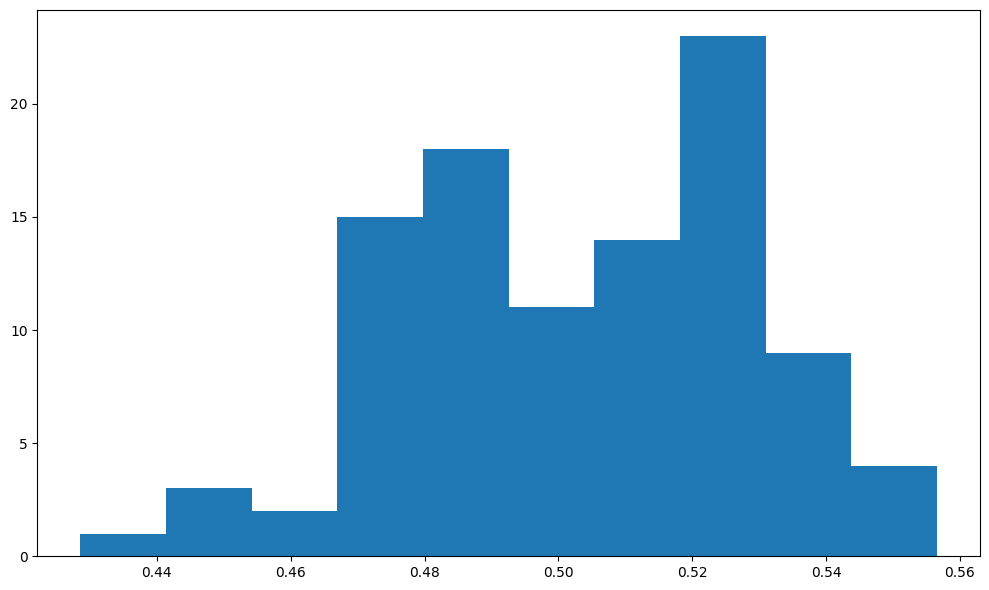

In [135]:
def normal_random(sample_size=100):
    sample = [random.uniform(0,1) for _ in range(sample_size) ]
    return sum(sample)/sample_size

sample = [normal_random() for _ in range(100)]
plt.figure(figsize=(10,6))
plt.hist(sample)
plt.tight_layout()
plt.show()

## Корреляция и Злая Бейсбольная Корпорация

Корреляция позволяет нам находить связи между последовательностями данных. В нашем учебном примере представим, что существует злая бейсбольная корпорация, которая платит своим игрокам в зависимости от их роста — чем выше игрок, тем больше он/она получает денег. Предположим, что существует базовая зарплата в размере $1000, а также дополнительный бонус от $0 до $100, в зависимости от роста. Мы возьмем реальных игроков из MLB и вычислим их воображаемые зарплаты:


In [136]:
heights = df['Height']
salaries = 1000+(heights-heights.min())/(heights.max()-heights.mean())*100
print(list(zip(heights, salaries))[:10])

[(180, 1033.985209531635), (215, 1073.6346206518763), (210, 1067.9704190632704), (210, 1067.9704190632704), (188, 1043.0479320734046), (176, 1029.4538482607504), (209, 1066.837578745549), (200, 1056.6420158860585), (231, 1091.760065735415), (180, 1033.985209531635)]


Давайте теперь вычислим ковариацию и корреляцию этих последовательностей. `np.cov` даст нам так называемую **ковариационную матрицу**, которая является расширением ковариации на несколько переменных. Элемент $M_{ij}$ ковариационной матрицы $M$ представляет собой корреляцию между входными переменными $X_i$ и $X_j$, а диагональные значения $M_{ii}$ — это дисперсия $X_{i}$. Аналогично, `np.corrcoef` даст нам **матрицу корреляции**.


In [137]:
print(f"Covariance matrix:\n{np.cov(heights, salaries)}")
print(f"Covariance = {np.cov(heights, salaries)[0,1]}")
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Covariance matrix:
[[441.63557066 500.30258018]
 [500.30258018 566.76293389]]
Covariance = 500.3025801786725
Correlation = 0.9999999999999997


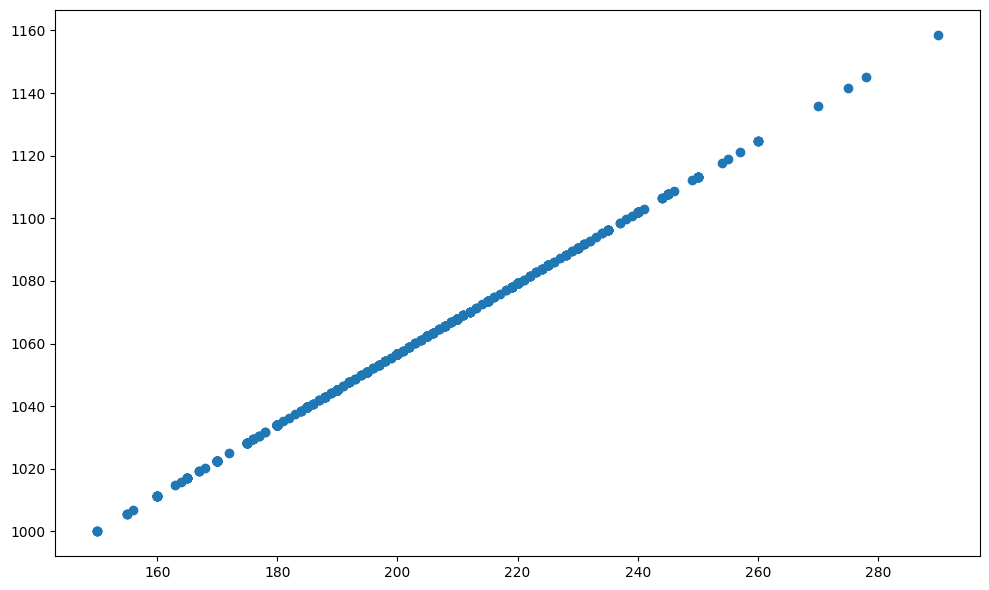

In [138]:
plt.figure(figsize=(10,6))
plt.scatter(heights,salaries)
plt.tight_layout()
plt.show()

In [139]:
salaries = 1000+np.sin((heights-heights.min())/(heights.max()-heights.mean()))*100
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Correlation = 0.9910655775558532


В этом случае корреляция немного меньше, но все же довольно высокая. Теперь, чтобы сделать связь еще менее очевидной, мы могли бы добавить немного дополнительной случайности, добавив некоторую случайную переменную к зарплате. Давайте посмотрим, что произойдет:


In [140]:
salaries = 1000+np.sin((heights-heights.min())/(heights.max()-heights.mean()))*100+np.random.random(size=len(heights))*20-10
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Correlation = 0.948230287835537


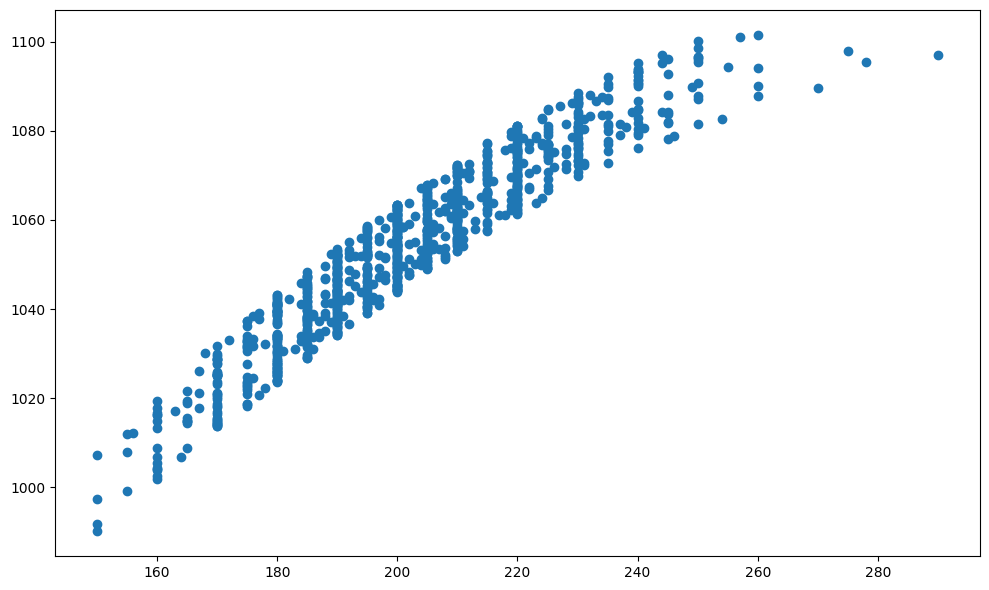

In [141]:
plt.figure(figsize=(10,6))
plt.scatter(heights, salaries)
plt.tight_layout()
plt.show()

> Можете догадаться, почему точки выстраиваются в вертикальные линии таким образом?

Мы наблюдали корреляцию между искусственно созданной концепцией, такой как зарплата, и наблюдаемой переменной *рост*. Давайте также посмотрим, коррелируют ли две наблюдаемые переменные, такие как рост и вес:


In [142]:
np.corrcoef(df['Height'],df['Weight'])

array([[1.        , 0.52959196],
       [0.52959196, 1.        ]])

К сожалению, мы не получили никаких результатов — только странные значения `nan`. Это связано с тем, что некоторые значения в нашей серии неопределены и представлены как `nan`, что приводит к тому, что результат операции также становится неопределенным. Если посмотреть на матрицу, можно заметить, что проблемной колонкой является `Weight`, так как была вычислена автокорреляция значений `Height`.

> Этот пример подчеркивает важность **подготовки данных** и **очистки данных**. Без корректных данных мы не можем ничего вычислить.

Давайте воспользуемся методом `fillna`, чтобы заполнить пропущенные значения, и вычислим корреляцию:


In [143]:
np.corrcoef(df['Height'],df['Weight'].fillna(method='pad'))

array([[1.        , 0.52959196],
       [0.52959196, 1.        ]])

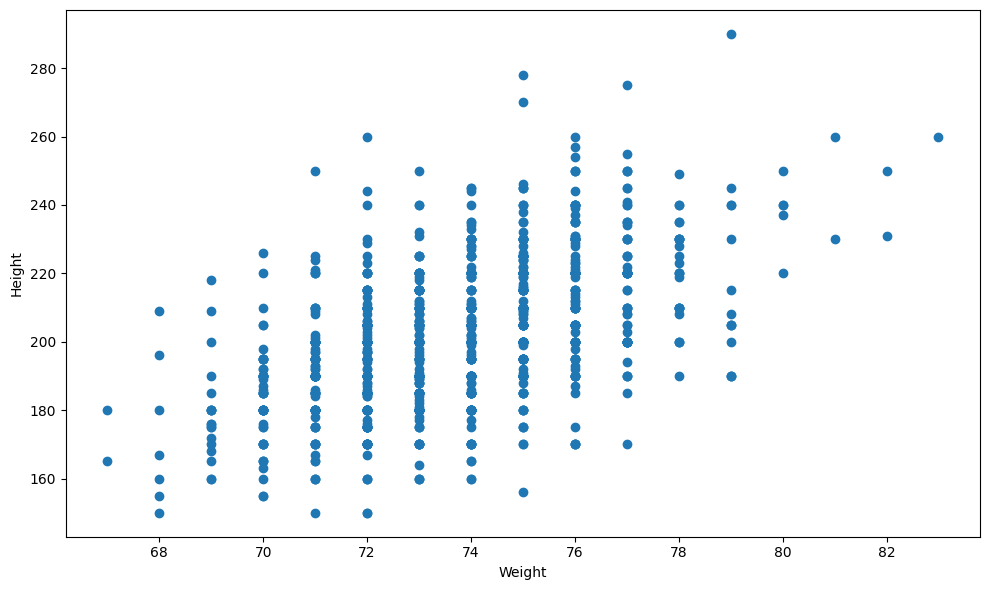

In [144]:
plt.figure(figsize=(10,6))
plt.scatter(df['Weight'],df['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

## Заключение

В этом блокноте мы изучили, как выполнять базовые операции с данными для вычисления статистических функций. Теперь мы знаем, как использовать надежный аппарат математики и статистики для проверки гипотез, а также как вычислять доверительные интервалы для произвольных переменных на основе выборки данных.



---

**Отказ от ответственности**:  
Этот документ был переведен с помощью сервиса автоматического перевода [Co-op Translator](https://github.com/Azure/co-op-translator). Хотя мы стремимся к точности, пожалуйста, имейте в виду, что автоматические переводы могут содержать ошибки или неточности. Оригинальный документ на его исходном языке следует считать авторитетным источником. Для получения критически важной информации рекомендуется профессиональный перевод человеком. Мы не несем ответственности за любые недоразумения или неправильные толкования, возникшие в результате использования данного перевода.
